## Week 4 Homework

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import auc, roc_auc_score, precision_recall_curve, precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import seaborn as sns


In [3]:
# Data import and prep
df = pd.read_csv('AER_credit_card_data.csv')
df['target'] = np.where(df['card']=='yes', 1,0)

X = df.drop(columns=['target','card'])
y = df['target']
# Split into test and train at 60/40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=1)

# now split into train and validation to give 60/20/20 split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

In [37]:
# Question 1
numeric = ['reports', 'dependents', 'active','share'] 

for variable in numeric:
    model = LogisticRegression(solver="liblinear", random_state=1)
    train = X_train[variable].to_numpy().reshape(-1,1)
    model.fit(train, y_train)
    score = roc_auc_score(y_train, model.predict_proba(train)[:, 1])
    print(f"AUC for {variable} column: {score}")

AUC for reports column: 0.660960591133005
AUC for dependents column: 0.542816091954023
AUC for active column: 0.6282019704433498
AUC for share column: 0.9814039408866996


In [7]:
# Question 2

def df_prep_and_split(df):
    df = df[["target","reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]]

    X = df.drop(columns=['target'])
    y = df['target']
    # Split into test and train at 60/40
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=1)

    # now split into train and validation to give 60/20/20 split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

    categoric = ['owner','selfemp']
    numeric = ['reports',	'age',	'income',	'share',	'expenditure',	'dependents',	'months',	'majorcards',	'active']
    # One hot encode categoricals using a dict vectorizer
    train_dict = X_train[categoric + numeric].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)
    X_train = dv.transform(train_dict)

    # One hot encode validation data for model metrics
    val_dict = X_val[categoric + numeric].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    return X_train, X_test, y_train, X_val, y_test, y_val

X_train, X_test, y_train, X_val, y_test, y_val = df_prep_and_split(df)


In [8]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
score = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
print(f"AUC is: {round(score,5)}")

AUC is: 0.99984


<AxesSubplot:xlabel='Threshold', ylabel='Recall'>

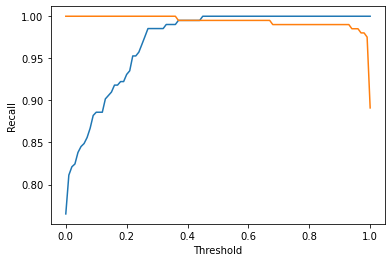

In [87]:
# Question 3
recall_scores = []
precision_scores = []
thresholds = np.linspace(0, 1, 101)
y_pred = model.predict_proba(X_val)[:, 1]

for threshold in thresholds:
    recall = recall_score(y_val, y_pred >= threshold)
    precision_scores.append(recall)
    precision = precision_score(y_val, y_pred >= threshold)
    recall_scores.append(precision)

plt_df = pd.DataFrame(list(zip(thresholds, recall_scores, precision_scores)),
               columns =['Threshold', 'Recall', 'Precision'])
sns.lineplot(x='Threshold', y='Recall', data=plt_df)
sns.lineplot(x='Threshold', y='Precision', data=plt_df)

Curves intersect at 0.3 Threshold

In [74]:
## Question 4 
# Use the dataframe created to make above plot to create new column for F1 scores
plt_df['F1_score'] = 2 * plt_df['Precision'] * plt_df['Recall'] / (plt_df['Precision'] + plt_df['Recall'])

In [85]:
max_F1 = plt_df['F1_score'].max()
plt_df[plt_df['F1_score']==max_F1]
# based on below output the max F1 score appears arouund 0.4 Threshold

,Threshold,Recall,Precision,F1_score
45,0.45,1.0,0.99505,0.997519
46,0.46,1.0,0.99505,0.997519
47,0.47,1.0,0.99505,0.997519
48,0.48,1.0,0.99505,0.997519
49,0.49,1.0,0.99505,0.997519
50,0.50,1.0,0.99505,0.997519
51,0.51,1.0,0.99505,0.997519
52,0.52,1.0,0.99505,0.997519
53,0.53,1.0,0.99505,0.997519
54,0.54,1.0,0.99505,0.997519


In [16]:
# ## Question 5

# # Create function to run k fold validation
# # Create df_train_full
# def k_folds_validation(df, kfoldsplit):

#     kfold = KFold(n_splits=kfoldsplit, shuffle=True, random_state=1)


#     # Use functions from Learning material
#     def train(df, y):
#         cat = df[categoric + numeric].to_dict(orient='records')
        
#         dv = DictVectorizer(sparse=False)
#         dv.fit(cat)

#         X = dv.transform(cat)

#         model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
#         model.fit(X, y)

#         return dv, model


#     def predict(df, dv, model):
#         cat = df[categoric + numeric].to_dict(orient='records')
        
#         X = dv.transform(cat)

#         y_pred = model.predict_proba(X)[:, 1]

#         return y_pred



#     df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
#     df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

#     y_train = df_train['target'].values
#     y_val = df_val['target'].values

#     del df_train['target']
#     del df_val['target']


#     # get Kfolds AUCs - using code from the learning material
#     aucs = []

#     for train_idx, val_idx in kfold.split(df_train_full):
#         df_train = df_train_full.iloc[train_idx]
#         y_train = df_train['target'].values

#         df_val = df_train_full.iloc[val_idx]
#         y_val = df_val['target'].values

#         dv, model = train(df_train, y_train)
#         y_pred = predict(df_val, dv, model)

#         rocauc = roc_auc_score(y_val, y_pred)
#         aucs.append(rocauc)
    
#     return aucs

# # Call function
# aucs = k_folds_validation(df, 5)
#     # Finally get the standard deviation
#     # Standard deviation of list
# # Using sum() + list comprehension
# mean = sum(aucs) / len(aucs)
# std = (sum([((x - mean) ** 2) for x in aucs]) / len(aucs))**0.5
# std

In [17]:
# Question 5 - Using custom code with sklearn using cross_val_score
CV = KFold(n_splits=5, shuffle=True, random_state=1)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

X_train, X_test, y_train, X_val, y_test, y_val = df_prep_and_split(df)

# Run cross validation score with auc as the metric
scores = cross_val_score(model, X_train, y_train, cv=CV, scoring='roc_auc')

print("%0.4f AUC with a standard deviation of %0.4f" % (scores.mean(), scores.std()))


0.9798 AUC with a standard deviation of 0.0194


In [23]:
## Question 6
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
C = [0.01, 0.1, 1, 10]
output = {}
for value in C:
    model = LogisticRegression(solver='liblinear', C=value, max_iter=1000)
    scores = cross_val_score(model, X_train, y_train, cv=CV, scoring='roc_auc')
    output[value] = [scores.mean(), scores.std()]

# Get output of best value
output

{0.01: [0.9767644956669347, 0.02362699622284424],
 0.1: [0.9814630491459759, 0.018235770785871228],
 1: [0.9798182305499379, 0.019422980153699733],
 10: [0.9787496243593804, 0.01788478114639378]}